## Ensamblando un Pipeline the ingeniería de variables utilizando Feature-engine y validación cruzada

En este notebook, te mostraremos cómo usar Feature-engine con el Pipeline (tubería) de Scikit-learn, utilizando validación cruzada. 

Te mostraremos como:
- construir un árbol de potenciación de gradiente
- usar feature-engine para los pasos de ingeniería de variables
- construir un pipeline para toda la ingeniería de variables y predicción utilizando Scikit-learn Pipeline
- entrenar un pipeline con validación cruzada, evaluando diverentes parámetros para la ingeniería de variables

============================================================================

## En este demo:

Usaremos los datos del Titanic. Fíjate en la lección de Datos de la Sección 1 del curso para las instrucciones de como descargar y preparar los datos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# para el modelo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# para la ingeniería de variables
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

In [2]:
# cargar los datos

cols = [
    'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
    'embarked', 'survived'
]

data = pd.read_csv('../titanic.csv', usecols=cols)

data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,1,1,female,29.0000,0,0,211.3375,B5,S
1,1,1,male,0.9167,1,2,151.5500,C22,S
2,1,0,female,2.0000,1,2,151.5500,C22,S
3,1,0,male,30.0000,1,2,151.5500,C22,S
4,1,0,female,25.0000,1,2,151.5500,C22,S


In [3]:
# Cabin: extraer la parte numérica y categórica y
# borrar la variable original

data['cabin_num'] = data['cabin'].str.extract('(\d+)') # captura la parte numérica
data['cabin_num'] = data['cabin_num'].astype('float')
data['cabin_cat'] = data['cabin'].str[0] # captura la primera letra 

data.drop(['cabin'], axis=1, inplace=True)

In [4]:
# crear lista con los tipos de variables

# numérica: discreta y continua
discrete = [
    var for var in data.columns if data[var].dtype != 'O' and var != 'survived'
    and data[var].nunique() < 10
]
continuous = [
    var for var in data.columns
    if data[var].dtype != 'O' and var != 'survived' and var not in discrete
]

# categórica
categorical = [var for var in data.columns if data[var].dtype == 'O']

print('Hay {} variables discretas'.format(len(discrete)))
print('Hay {} variables continuas'.format(len(continuous)))
print('Hay {} variables categóricas'.format(len(categorical)))

Hay 3 variables discretas
Hay 3 variables continuas
Hay 3 variables categóricas


In [5]:
# separar en sets de entrenamiento y prueba 

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictores
    data['survived'],  # target
    test_size=0.1,  # porcentaje de obs in set de prueba
    random_state=0)  # semilla para garantizar reproducibilidad
X_train.shape, X_test.shape

((1178, 9), (131, 9))

### Contruir pipeline (tubería)

In [6]:
titanic_pipe = Pipeline([

    # imputación datos faltantes- sección 4
    ('imputer_num',
     mdi.ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=['age', 'fare', 'cabin_num'])),
    ('imputer_cat',
     mdi.CategoricalVariableImputer(variables=['embarked', 'cabin_cat'])),

    # codificación variables categóricas - sección 6
    ('encoder_rare_label',
     ce.RareLabelCategoricalEncoder(tol=0.01,
                                    n_categories=2,
                                    variables=['embarked', 'cabin_cat'])),
    ('categorical_encoder',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=['cabin_cat', 'sex', 'embarked'])),

    # máquina de potenciación de gradiente
    ('gbm', GradientBoostingClassifier(random_state=0))
])

## Cuadrícula de parámetros y estrategia de validación cruzada 

In [7]:
# creamos la cuadrícula con todos los parámetros
# that we would like to test

param_grid = {
    # evaluar diferentes opciones de ingeniería de variables
    'imputer_num__arbitrary_number': [-1, 99],
    'encoder_rare_label__tol': [0.1, 0.2],
    'categorical_encoder__encoding_method': ['ordered', 'arbitrary'],
    
    # evaluar diferentes parámetros máquina de potenciación de gradiente
    'gbm__max_depth': [None, 1, 3],
}


# cuadricula para la búsqueda de parámetros (GridSearch)
# with validación cruzada 
grid_search = GridSearchCV(titanic_pipe, param_grid,
                           cv=5, iid=False, n_jobs=-1, scoring='roc_auc')

# cv=5 número de pasos validación cruzada
# no_jobs =-1 indica que todos los cpus se deben usar
# scoring='roc-auc' indica que el desempeño del modelo se debe evaluar 
# con el roc-auc

# si quieres más información acerca de los parámetros visita el
# siguiente enlace de skitlearn
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [8]:
# y ahora entrenamos evaluando todas las combinaciones 
# de los parámetros fijados en la celda anterior
grid_search.fit(X_train, y_train)

# imprimimos el mejor puntaje en el set de entrenamiento
print(("Mejor roc-auc en la cuadricula para la búsqueda de parámetros: %.3f"
       % grid_search.score(X_train, y_train)))

Mejor roc-auc en la cuadricula para la búsqueda de parámetros: 0.930


In [9]:
# también podemos imprimir los parámetros
# para el mejor estimador así:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('imputer_num',
                 ArbitraryNumberImputer(arbitrary_number=99,
                                        variables=['age', 'fare',
                                                   'cabin_num'])),
                ('imputer_cat',
                 CategoricalVariableImputer(variables=['embarked',
                                                       'cabin_cat'])),
                ('encoder_rare_label',
                 RareLabelCategoricalEncoder(n_categories=2, tol=0.1,
                                             variables=['embarked',
                                                        'cabin_cat'])),
                ('categorical_encoder',
                 OrdinalCatego...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                      

In [10]:
# y podemos ver los parámetros óptimos encontrados de la cuadrícula así:
grid_search.best_params_

{'categorical_encoder__encoding_method': 'ordered',
 'encoder_rare_label__tol': 0.1,
 'gbm__max_depth': 3,
 'imputer_num__arbitrary_number': 99}

In [11]:
# aquí podemos ver todas las combinaciones evaluadas
# durante el gridsearch
grid_search.cv_results_['params']

[{'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': None,
  'imputer_num__arbitrary_number': -1},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': None,
  'imputer_num__arbitrary_number': 99},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': 1,
  'imputer_num__arbitrary_number': -1},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': 1,
  'imputer_num__arbitrary_number': 99},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': 3,
  'imputer_num__arbitrary_number': -1},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': 3,
  'imputer_num__arbitrary_number': 99},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.2,
  'gbm_

In [12]:
# aquí podemos ver el puntaje por cada una de las combinaciones
# de parámetros
grid_search.cv_results_['mean_test_score']

array([0.82947986, 0.8286403 , 0.84155143, 0.84542691, 0.86242112,
       0.86825992, 0.82964545, 0.83183916, 0.84221378, 0.84529895,
       0.86267702, 0.86760509, 0.82746927, 0.82427869, 0.84168279,
       0.84558796, 0.86236819, 0.86787681, 0.82859828, 0.82770335,
       0.84240535, 0.84546753, 0.86230045, 0.86766606])

In [13]:
# y finalmente revisemos el desempeño en el set the prueba
print(("best linear regression from grid search: %.3f"
       % grid_search.score(X_test, y_test)))

best linear regression from grid search: 0.848


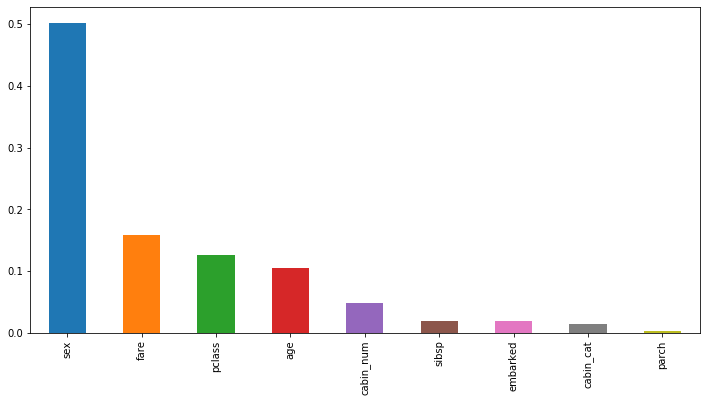

In [14]:
# exploremos la importancia de cada una de las variables

importance = pd.Series(grid_search.best_estimator_['gbm'].feature_importances_)
importance.index = data.drop('survived', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))